# Summary plot

__last update__: 16/05/22

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
import copy
import numpy as np
import pickle as pkl
from astropy.io import fits
from scipy.optimize import minimize
import seaborn as sns # for nicer colors on the plot

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, ListedColormap, TwoSlopeNorm
from matplotlib import patches as mpatches
plt.rc('image', interpolation='none', origin='lower')
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

from herculens.Util.plot_util import nice_colorbar, nice_colorbar_residuals

In [2]:
scenario = 'ideal'
scale_factor = 3
with_smooth_model_results = False

SAVE_FIGURES_FULL = False
SAVE_FIGURES_SMOOTH = False
figure_dir = os.path.join('figures', 'fit summaries')

SAVE_PANELS_AS_FITS = False
figure_dir_panels = os.path.join('figures', 'fit summaries', 'separate panels')

In [3]:
# Define some custom colormaps
#try:
#    import palettable
#except ImportError:
#    cmap_base = plt.get_cmap('cubehelix')
#else:
#    cmap_base = palettable.cubehelix.Cubehelix.make(name='flux_colormap',
#                                                    start=0.5,
#                                                    rotation=-1,
#                                                    gamma=0.8,
#                                                    sat=0.8,
#                                                    n=256).mpl_colormap
cmap_base = copy.copy(plt.get_cmap('magma'))
cmap_base.set_under('black')
cmap_base.set_over('white')
cmap_flux = copy.copy(cmap_base)
cmap_flux.set_bad(color='black')
cmap_flux_alt = copy.copy(cmap_base)
cmap_flux_alt.set_bad(color='#222222')  # to emphasize non-positive pixels in log scale
cmap_res = plt.get_cmap('RdBu_r')
cmap_corr = copy.copy(plt.get_cmap('Spectral_r'))
cmap_corr_cut = ListedColormap(cmap_corr(np.linspace(0.5, 1, 128)))
cmap_default = plt.get_cmap('viridis')
cmap_deriv1 = plt.get_cmap('cividis')
cmap_deriv2 = plt.get_cmap('inferno')

In [4]:
# types of potential perturbations we consider
perturb_types = {
    f'{scenario}-dark_halo': "LS", 
    f'{scenario}-GRF': "PS", 
    f'{scenario}-discyness': "HM"
}

# for each case, load the saved data from the modeling
full_model_data, smooth_model_data, pixsrc_model_data = {}, {}, {}
full_hmc_data = {}
for perturb_type in perturb_types.keys():
    if scenario == 'real':
        suffix = '-init_from_smooth'
    else:
        suffix = ''
    with open(os.path.join('results', 'fiducial_regul_strength', f'sumplot-{perturb_type}-scale_{scale_factor}-smooth_source{suffix}.pkl'), 'rb') as f:
        content = pkl.load(f)
        full_model_data[perturb_type] = content
    if scenario == 'real':
        # load HMC samples as well
        nsamples = 400
        with open(os.path.join('results', 'fiducial_regul_strength', f'samples_HMC_n{nsamples}-{perturb_type}-scale_{scale_factor}-smooth_source{suffix}.pkl'), 'rb') as f:
            content = pkl.load(f)
            full_hmc_data[perturb_type] = content
    
    if with_smooth_model_results:
        with open(os.path.join('results', f'sumplot-{perturb_type}-smooth_potential-smooth_source.pkl'), 'rb') as f:
            content = pkl.load(f)
            smooth_model_data[perturb_type] = content
        with open(os.path.join('results', f'sumplot-{perturb_type}-smooth_potential-wavelet_source.pkl'), 'rb') as f:
            content = pkl.load(f)
            pixsrc_model_data[perturb_type] = content

In [5]:
def optimal_offset(model, target, mask=None, noise_map=None):
    """Function to minimize constant offset between two images."""
    if mask is None: mask = np.ones_like(target)
    if noise_map is None: noise_map = np.ones_like(model)
    loss_fun = lambda offset: 0.5 * np.sum(mask*(model+offset - target)**2/noise_map**2)
    init_offset = 0.
    result = minimize(loss_fun, init_offset)
    final_offset = float(result.x[0])
    return final_offset 

def levels_for_source(image, frac_levels=[0.5], n=1000):
    """compute specific levels from an image, based on fraction of the total flux.
    Useful for getting an (approximated) half-light radius from an image.
    Note that 'total light' here is defined as the sum of the `image` pixels.
    """
    from scipy import interpolate
    z = np.array(image)
    t = np.linspace(0.0, z.max(), n)
    integral = ((z >= t[:, None, None]) * z).sum(axis=(1, 2))
    f = interpolate.interp1d(integral, t)
    levels = f(np.array(frac_levels) * z.sum())
    return levels

In [6]:
def set_column_title(ax, title, fontsize=16):
    ax.text(0.5, 1.05, title, transform=ax.transAxes, 
            ha='center', va='bottom', fontsize=fontsize)
    
def set_row_title(ax, title, fontsize=16):
    #ax.text(0, 0.5, title, transform=ax.transAxes,
    #        ha='left', va='center', fontsize=fontsize)
    ax.text(-0.25, 0.5, title, transform=ax.transAxes, rotation=90,
            ha='left', va='center', fontsize=fontsize)
    
def add_scale_bar(ax, extent, pixel_size, size_arcsec=1, bar_width_pixel=1, 
                  position=None, color='white', fontsize=16):
    if position is None:
        position = (extent[0]+5*pixel_size, extent[2]+5*pixel_size)
    width, height = size_arcsec, bar_width_pixel*pixel_size
    bar = mpatches.Rectangle(position, width, height, facecolor=color)
    ax.add_patch(bar)
    text_offset_y = 2 * height
    text = '{}"'.format(size_arcsec)
    ax.text(position[0]+width/2., position[1]+text_offset_y, text, color=color, fontsize=fontsize, 
            horizontalalignment='center', verticalalignment='bottom')

def add_title_box(ax, text, fontsize=16, txt_color='white', bg_color='black'):
    ax.text(0.05, 0.95, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.5})
    
def add_text_box(ax, text, loc='right', fontsize=16,
                 txt_color='black', txt_alpha=1,
                 bg_color='white', bg_alpha=1):
    if loc == 'right':
        x, y = 0.95, 0.05
        ha, va = 'right', 'bottom'
    elif loc == 'left':
        x, y = 0.05, 0.05
        ha, va = 'left', 'bottom'
    elif loc == 'top left':
        x, y = 0.05, 0.95
        ha, va = 'left', 'top'
    elif loc == 'top right':
        x, y = 0.95, 0.95
        ha, va = 'right', 'top'
    ax.text(x, y, text, color=txt_color, alpha=txt_alpha, fontsize=fontsize, 
            horizontalalignment=ha, verticalalignment=va,
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': bg_alpha})
    
def add_imshow_inset(ax, image, edge_color='white', **kwargs_imshow):
    w, h = 0.35, 0.35 # relative to ax size
    ax_ins = ax.inset_axes([-0.05, 1.05-h, w, h])
    ax_ins.set_xticks([]); ax_ins.set_yticks([])
    im_ins = ax_ins.imshow(image, **kwargs_imshow)
    im_ins.set_rasterized(True)
    ax_ins.spines['bottom'].set_color(edge_color)
    ax_ins.spines['top'].set_color(edge_color)
    ax_ins.spines['left'].set_color(edge_color)
    ax_ins.spines['right'].set_color(edge_color)
    return ax_ins

=== IDEAL-DARK_HALO (lens LS) ===
total pixelated kappa within mask: 10.49958
mean within mask: 0.2058567
potential model offset = 0.136
=== IDEAL-GRF (lens PS) ===


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:163: UserWarning: No contour levels were found within the data range.
/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:204: UserWarning: No contour levels were found within the data range.


total pixelated kappa within mask: 34.272125
mean within mask: 0.009151454
potential model offset = 0.000
=== IDEAL-DISCYNESS (lens HM) ===
total pixelated kappa within mask: 2.7752674
mean within mask: 1.7246464e-05
potential model offset = 0.000


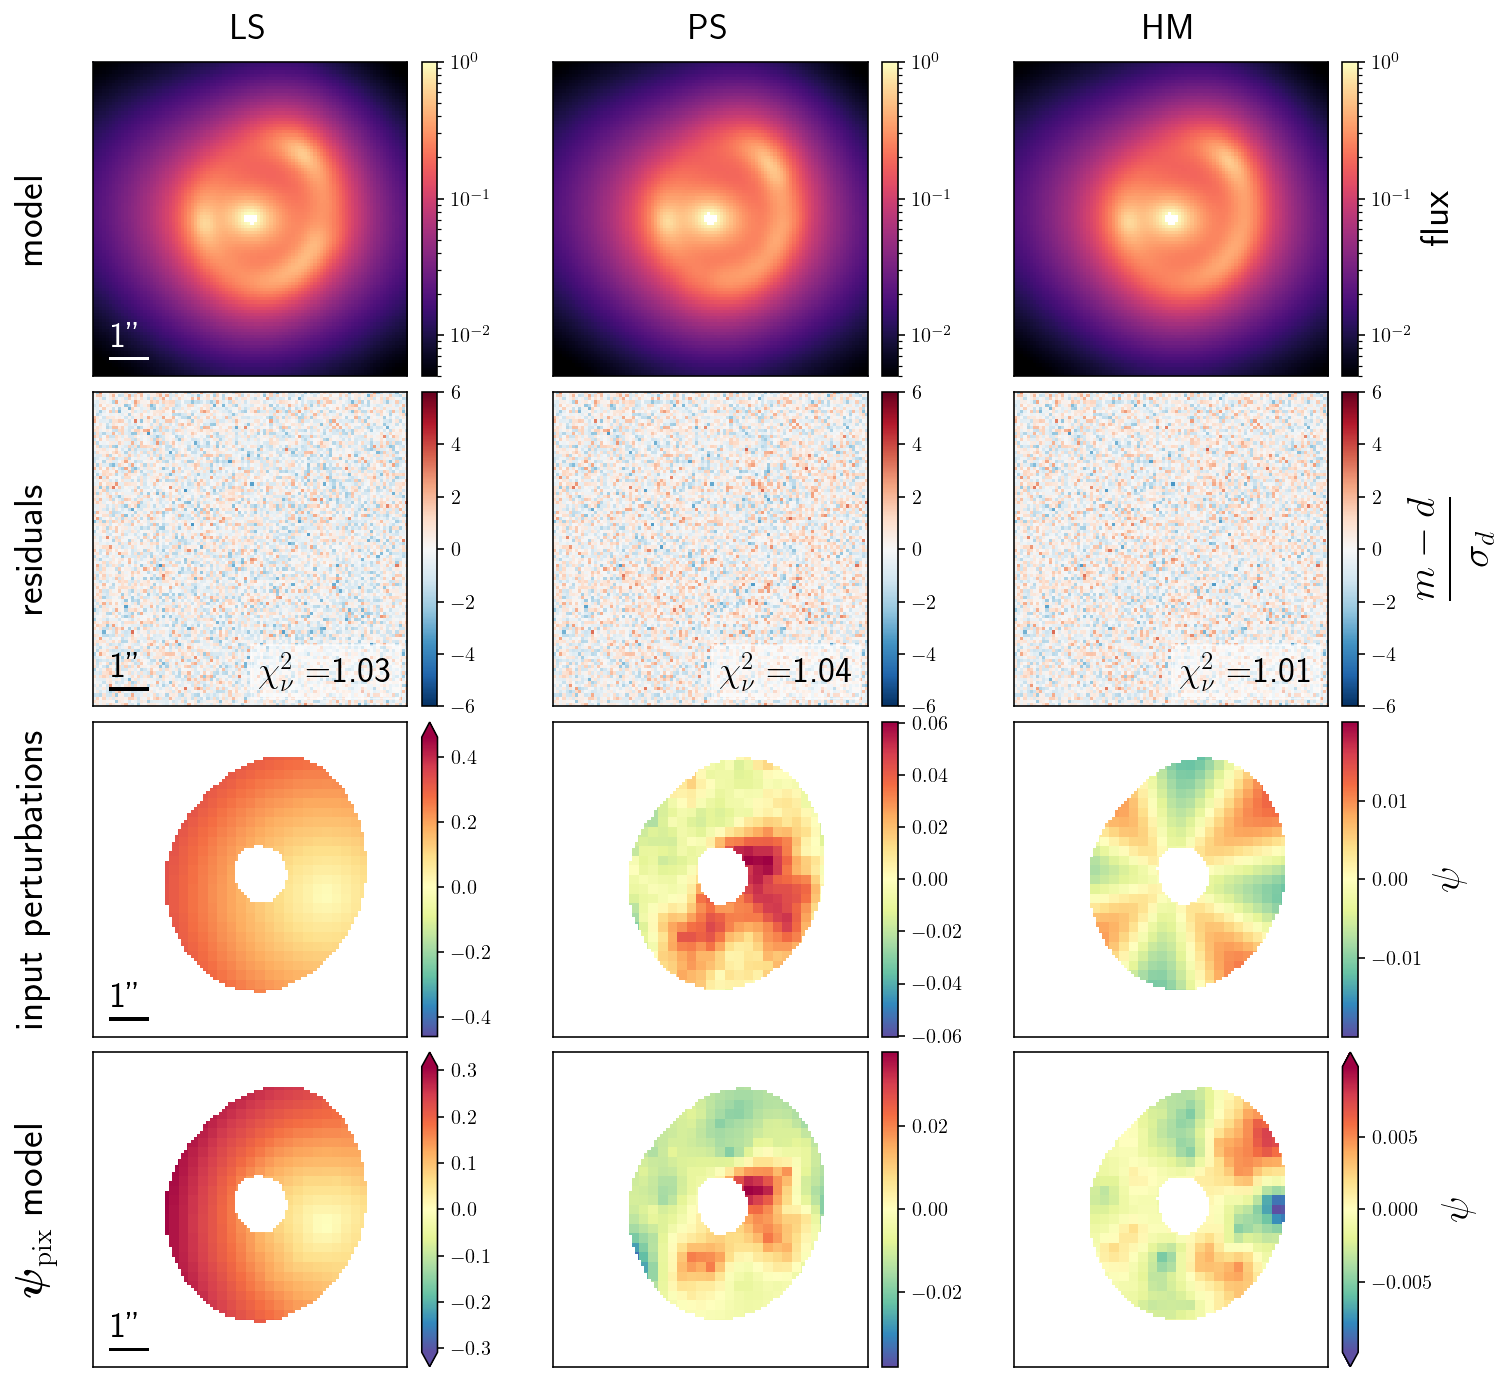

In [7]:
source_zoom_in = True
shared_pixpot_norms = False
mask_opacity, cont_opacity = 1, 0

trunc_fractor = 0.8  # only for dark halo

fontsize = 18
#fontsize_label = 16
fontsize_row = 20
fontsize_cb = 20
cb_pad = 0.1

#norm_flux = LogNorm(10**(-1.5), 10**(1))
norm_flux = LogNorm(5e-3, 1e0)
norm_res = Normalize(-6, 6)
norm_diff_src = Normalize(-0.5, 0.5)
#norm_pot = Normalize(-0.05, 0.05)
norm_res_pot = Normalize(-1, 1)
norm_pot_err = TwoSlopeNorm(0) # LogNorm()
norm_pot_snr = Normalize(0)

# FIGURE 1
num_cols = len(perturb_types)
if scenario == 'real':
    num_rows = 6
    figsize = (12, 17)
elif scenario == 'ideal':
    num_rows = 4
    figsize = (12, 12)
fig, axes = plt.subplots(num_rows, num_cols,
                         #gridspec_kw={'width_ratios':[0.6]+[1]*num_cols},
                         figsize=figsize)
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

# FIGURE 2
if with_smooth_model_results:
    num_rows2 = 2
    num_cols2 = len(perturb_types)
    fig2, axes2 = plt.subplots(num_rows2, num_cols2,
                               #gridspec_kw={'width_ratios':[0.6]+[1]*num_cols2},
                               figsize=(12, 6))
    for ax in axes2.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
for i, (perturb_type, perturb_name) in enumerate(perturb_types.items()):
    print(f"=== {perturb_type.upper()} (lens {perturb_name}) ===")
    
    ################### FULL MODEL PLOT ####################
    
    # load all necessary data
    data, full_lens_image, full_kwargs_result, input_kwargs_result, \
        potential_mask, potential_noise_map, \
        perturb_input, perturb_input_fitgrid, \
        _, cov_matrix_pixpot, _, _, _, _ \
        = full_model_data[perturb_type]
    
    extent = full_lens_image.Grid.extent
    pixel_size = full_lens_image.Grid.pixel_width
    x_grid, y_grid = full_lens_image.Grid.pixel_coordinates
    x_grid_fit, y_grid_fit = full_lens_image.Grid.model_pixel_coordinates('lens')
    
    full_model = full_lens_image.model(**full_kwargs_result)
    
    full_model = full_lens_image.model(**full_kwargs_result)
    full_noise_map = np.sqrt(full_lens_image.Noise.C_D_model(full_model))
    full_res = (full_model - data) / full_noise_map
    full_red_chi2 = np.sum(full_res**2) / full_res.size
    
    perturb_model = full_kwargs_result['kwargs_lens'][-1]['pixels']
    
    perturb_error = np.sqrt(np.abs(cov_matrix_pixpot))
    perturb_error = perturb_error.reshape(*perturb_model.shape)
    
    source_model = full_lens_image.source_surface_brightness(full_kwargs_result['kwargs_source'], 
                                                              kwargs_lens=full_kwargs_result['kwargs_lens'])
    
    # generate masks for potential perturbations
    rmin, rmax = 0.8, 2.8
    radius_fit = np.hypot(x_grid_fit, y_grid_fit)
    pot_mask_fitgrid = ((radius_fit >= rmin) & (radius_fit <= rmax)).astype(float)
    radius = np.hypot(x_grid, y_grid)
    pot_mask = ((radius >= rmin) & (radius <= rmax)).astype(float)
    
    # print BIC changes
    #delta_bic_pix_to_smooth_source = np.sqrt(smooth_red_chi2) + (np.log(num_data) * num_param) - np.sqrt(pixsrc_red_chi2) + (np.log(num_data) * num_param)

    # SNR source arc mask
    lensed_src = full_lens_image.model(**full_kwargs_result, lens_light_add=False)
    src_snr = lensed_src / np.sqrt(full_lens_image.Noise.C_D_model(lensed_src))
    src_mask = (src_snr > 5).astype(float)
    bx_grid_fit, by_grid_fit = full_lens_image.LensModel.ray_shooting(x_grid_fit, y_grid_fit, full_kwargs_result['kwargs_lens'])
    lensed_src_fitgrid = full_lens_image.SourceModel.surface_brightness(bx_grid_fit, by_grid_fit, full_kwargs_result['kwargs_source'])
    lensed_src_fitgrid *= full_lens_image.Grid.pixel_area
    src_snr_fitgrid = lensed_src_fitgrid / np.sqrt(full_lens_image.Noise.C_D_model(lensed_src_fitgrid, force_recompute=True))
    src_mask_fitgrid = np.array((src_snr_fitgrid > 5).astype(float))
    src_mask_nans = np.nan*np.zeros_like(src_mask)
    src_mask_nans[src_mask == 0] = 1
    
    # total reconstructed convergence
    perturb_kappa_model = full_lens_image.LensModel.kappa(x_grid_fit, y_grid_fit, full_kwargs_result['kwargs_lens'], k=-1)
    perturb_kappa_model = full_lens_image.LensModel.kappa(x_grid_fit, y_grid_fit, [{}, {}, {'pixels': perturb_input_fitgrid}], k=-1)
    kappa_mask = ((perturb_kappa_model > 0) & (src_mask_fitgrid == 1))
    print("total pixelated kappa within mask:", (perturb_kappa_model[kappa_mask]).sum())
    #plt.imshow(perturb_kappa_model * kappa_mask, origin='lower', cmap='plasma')
    #plt.show()
    #raise
        
    # misc
    first_col = (i == 0)
    last_col  = (i == num_cols-1)

    # 1) full model
    ax = axes[0, i]
    set_column_title(ax, f"{perturb_name}", fontsize=fontsize)
    if first_col:
        #add_text_box(ax, "model", loc='top left', fontsize=fontsize_label, txt_color='white', bg_alpha=0)
        set_row_title(ax, "model", fontsize=fontsize_row)
        add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                  color='white', fontsize=fontsize)
    im = ax.imshow(full_model, extent=extent, norm=norm_flux, cmap=cmap_flux)
    im.set_rasterized(True)
    label = "flux" if last_col else None
    nice_colorbar(im, pad=cb_pad, label=label, fontsize=fontsize_cb, invisible=False)
    
    # 2) image residuals for full model
    ax = axes[1, i]
    if first_col:
        #add_text_box(ax, "residuals", loc='top left', fontsize=fontsize_label, 
        #             txt_color='black', bg_color='white', bg_alpha=0.3)
        set_row_title(ax, "residuals", fontsize=fontsize_row)
        add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                  color='black', fontsize=fontsize)
    im = ax.imshow(full_res, extent=extent, norm=norm_res, cmap=cmap_res)
    im.set_rasterized(True)
    label = r"$\dfrac{m - d}{\sigma_d}$" if last_col else None
    nice_colorbar(im, pad=cb_pad, fontsize=fontsize_cb,
                  label=label, invisible=False)
    add_text_box(ax, r"$\chi^2_\nu=$"+f"{full_red_chi2:.2f}", 
                 fontsize=fontsize, txt_color='black', bg_color='white', bg_alpha=0.5)
    #ax_ins = add_imshow_inset(ax, src_diff, edge_color='black', extent=extent_src, norm=norm_diff_src, cmap=cmap_res)
    
    # 3) input potential perturbations
    ax = axes[2, i]
    print("mean within mask:", np.mean(perturb_input_fitgrid[pot_mask_fitgrid == 1].mean()))
    cmap_pot = cmap_corr
    if first_col:
        set_row_title(ax, r"input perturbations", fontsize=fontsize_row)
        add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                      color='black', fontsize=fontsize)
    perturb_input_fitgrid_plt = perturb_input_fitgrid.copy()
    #perturb_input_fitgrid_plt[src_mask == 0] = np.nan
    vmax = np.abs(perturb_input_fitgrid).max()
    if 'dark_halo' in perturb_type:
        vmax *= trunc_fractor
    norm_pot = Normalize(-vmax, vmax)
    im = ax.imshow(perturb_input_fitgrid_plt, 
                   extent=extent, cmap=cmap_pot, norm=norm_pot)
    im.set_rasterized(True)
    ax.imshow(src_mask_nans, extent=extent, cmap='gray_r', alpha=mask_opacity)
    ax.contour(src_mask, extent=extent, levels=[1], colors='black', linestyles='-', linewidths=1, alpha=cont_opacity)
    label = r"$\psi$" if last_col else None
    if 'dark_halo' in perturb_type:
        cb = nice_colorbar_residuals(im, perturb_input_fitgrid_plt, pad=cb_pad, label=label, 
                                     vmin=-vmax, vmax=vmax, fontsize=fontsize_cb)
    else:
        #cb = nice_colorbar(im, pad=cb_pad, label=label, fontsize=fontsize_cb)
        cb = nice_colorbar_residuals(im, perturb_input_fitgrid_plt, pad=cb_pad, label=label, 
                                     vmin=-vmax, vmax=vmax, fontsize=fontsize_cb)
    
    # 4) reconstructed potential perturbations
    ax = axes[3, i]
    if 'dark_halo' in perturb_type:
        offset_model = - perturb_model[potential_mask == 1].min() # + perturb_input_fitgrid.min()
        #offset_model = - perturb_model[src_mask_fitgrid == 0].mean()
        #offset_model = 0.
    elif 'discyness' in perturb_type:
        #offset_model = - perturb_input_fitgrid[potential_mask == 1].mean()
        offset_model = 0. #0.001
    else:
        #NOTE: potential_mask is 1 where source SNR > 5, 0 elsewhere
        offset_model = 0. #0.005
        #offset_model = - perturb_model[potential_mask == 1].mean() + perturb_input_fitgrid[potential_mask == 1].mean()
        #offset_model = optimal_offset(perturb_model, perturb_input_fitgrid, mask=potential_mask, 
        #                              noise_map=perturb_error)
    print(f"potential model offset = {offset_model:.3f}")
    perturb_model_o = (perturb_model + offset_model)  #*scale_factor
    vmax = np.abs(perturb_model_o[potential_mask==1]).max()
    #vmax = np.abs(perturb_model_o).max()
    if shared_pixpot_norms: # or 'dark_halo' in perturb_type:
        norm_pot_model = norm_pot
    else:
        norm_pot_model = Normalize(-vmax, vmax)
        
    if first_col:
        set_row_title(ax, r"$\boldsymbol{\psi}_{\rm pix}$ model", fontsize=fontsize_row)
        add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                  color='black', fontsize=fontsize)
    im = ax.imshow(perturb_model_o, extent=extent, cmap=cmap_pot, norm=norm_pot_model)
    im.set_rasterized(True)
    ax.imshow(src_mask_nans, extent=extent, cmap='gray_r', alpha=mask_opacity)
    ax.contour(src_mask, extent=extent, levels=[1], colors='black', linestyles='-', linewidths=1, alpha=cont_opacity)
    label = r"$\psi$" if last_col else None
    if 'dark_halo' in perturb_type:
        cb = nice_colorbar_residuals(im, perturb_model_o, pad=cb_pad, label=label, 
                                     vmin=-vmax, vmax=vmax, fontsize=fontsize_cb)
    else:
        #cb = nice_colorbar(im, pad=cb_pad, label=label, fontsize=fontsize_cb)
        cb = nice_colorbar_residuals(im, perturb_model_o, pad=cb_pad, label=label, 
                                     vmin=-vmax, vmax=vmax, fontsize=fontsize_cb)

    if scenario == 'real':
        num_lens, num_src = 5, 7
        samples_hmc, _, _, _ = full_hmc_data[perturb_type][3]
        
        # 5) perturbation standard deviation
        ax = axes[4, i]
        perturb_error_hmc = np.std(samples_hmc[:, num_lens:-num_src], axis=0).reshape(*perturb_model.shape)
        if first_col:
            #add_text_box(ax, r"$\psi_{\rm pix}$ error map", loc='top left', fontsize=fontsize_label, 
            #             txt_color='black', bg_color='white', bg_alpha=0.2)
            set_row_title(ax, r"$\boldsymbol{\psi}_{\rm pix}$ error", fontsize=fontsize_row)
            add_scale_bar(ax, extent, pixel_size, size_arcsec=1, color='black', fontsize=fontsize)
        im = ax.imshow(perturb_error_hmc, extent=extent, cmap=cmap_pot, norm=norm_pot_err)
        im.set_rasterized(True)
        #ax.imshow(src_mask_nans, extent=extent, cmap='gray_r', alpha=mask_opacity)
        label = r"$\sigma_{\psi_{\rm pix}}$" if last_col else None
        #nice_colorbar_residuals(im, perturb_error, pad=cb_pad, label=label, 
        #                        vmin=norm_pot_err.vmin, vmax=norm_pot_err.vmax,
        #                        fontsize=fontsize_cb, invisible=False)
        nice_colorbar(im, pad=cb_pad, fontsize=fontsize_cb,
                      label=label, invisible=False)

        # 9) SNR for model perturbations
        perturb_mean_hmc = np.mean(samples_hmc[:, num_lens:-num_src], axis=0).reshape(*perturb_model.shape)
        #perturb_model_snr = np.abs(perturb_mean_hmc) / perturb_error_hmc
        perturb_model_snr = np.abs(perturb_model) / perturb_error_hmc
        ax = axes[5, i]
        if first_col:
            set_row_title(ax, r"$\boldsymbol{\psi}_{\rm pix}$ SNR", fontsize=fontsize_row)
            add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                          color='white', fontsize=fontsize)
        im = ax.imshow(perturb_model_snr, extent=extent, norm=norm_pot_snr,
                       cmap=cmap_default)
        im.set_rasterized(True)
        #ax.imshow(src_mask_nans, extent=extent, cmap='gray_r', alpha=mask_opacity)
        label = r"$\dfrac{ \psi_{\rm pix} }{ \sigma_{\psi_{\rm pix}} }$" if last_col else None
        nice_colorbar(im, pad=cb_pad, fontsize=fontsize_cb,
                      label=label, invisible=False)
    
    
    
    
    ################### SMOOTH MODEL PLOT #####################
    
    
    if with_smooth_model_results:
        smooth_lens_image, smooth_kwargs_result = smooth_model_data[perturb_type][1:3]
        pixsrc_lens_image, pixsrc_kwargs_result = pixsrc_model_data[perturb_type][1:3]

        smooth_model = smooth_lens_image.model(**smooth_kwargs_result)
        smooth_noise_map = np.sqrt(smooth_lens_image.Noise.C_D_model(smooth_model))
        smooth_res = (smooth_model - data) / smooth_noise_map
        smooth_red_chi2 = np.sum(smooth_res**2) / smooth_res.size

        pixsrc_model = pixsrc_lens_image.model(**pixsrc_kwargs_result)
        pixsrc_noise_map = np.sqrt(pixsrc_lens_image.Noise.C_D_model(pixsrc_model))
        pixsrc_res = (pixsrc_model - data) / pixsrc_noise_map
        pixsrc_red_chi2 = np.sum(pixsrc_res**2) / pixsrc_res.size



        # 3) image residuals for smooth model with smooth source
        ax = axes2[0, i]
        set_column_title(ax, f"{perturb_name}", fontsize=fontsize)
        if first_col:
            #add_text_box(ax, "residuals", loc='top left', fontsize=fontsize_label, 
            #             txt_color='black', bg_color='white', bg_alpha=0.3)
            set_row_title(ax, "analytical source", fontsize=fontsize_row)
            add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                      color='black', fontsize=fontsize)
        im = ax.imshow(smooth_res, extent=extent, norm=norm_res, cmap=cmap_res)
        im.set_rasterized(True)
        nice_colorbar(im, pad=cb_pad, fontsize=fontsize_cb,
                      label=r"$\dfrac{m - d}{\sigma_d}$", 
                      invisible=False)
        add_text_box(ax, r"$\chi^2_\nu=$"+f"{smooth_red_chi2:.2f}", 
                     fontsize=fontsize, txt_color='black', bg_color='white', bg_alpha=0.5)
        #ax_ins = add_imshow_inset(ax, src_smo_diff, edge_color='black', extent=extent_src, norm=norm_diff_src, cmap=cmap_res)

        # 1.1) image residuals for smooth model with pixelated source
        ax = axes2[1, i]
        if first_col:
            set_row_title(ax, "pixelated source", fontsize=fontsize_row)
            add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                      color='black', fontsize=fontsize)
        im = ax.imshow(pixsrc_res, extent=extent, norm=norm_res, cmap=cmap_res)
        im.set_rasterized(True)
        nice_colorbar(im, pad=cb_pad, fontsize=fontsize_cb,
                      label=r"$\dfrac{m - d}{\sigma_d}$", 
                      invisible=False)
        add_text_box(ax, r"$\chi^2_\nu=$"+f"{pixsrc_red_chi2:.2f}", 
                     fontsize=fontsize, txt_color='black', bg_color='white', bg_alpha=0.5)

    
    
    #############################
    
    
    
    if SAVE_PANELS_AS_FITS:
        panel_basename = f"wavelet_pot-smooth_src-full_fit-type_{perturb_type.replace(' ', '_')}-"
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'data' + '.fits'),
                     np.array(data), overwrite=True)
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'full_model' + '.fits'),
                     np.array(full_model), overwrite=True)
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'smooth_resid' + '.fits'),
                     np.array(smooth_res), overwrite=True)
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'full_resid' + '.fits'),
                     np.array(full_res), overwrite=True)
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'input_pert' + '.fits'),
                     np.array(perturb_input_fitgrid), overwrite=True)
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'model_pert' + '.fits'),
                     np.array(perturb_model), overwrite=True)
        fits.writeto(os.path.join(figure_dir_panels, panel_basename + 'pot_mask' + '.fits'),
                     np.array(pot_mask_fitgrid), overwrite=True)
        
fig.subplots_adjust(hspace=0.05, wspace=0.1)
#fig.tight_layout()
if with_smooth_model_results:
    #fig2.subplots_adjust(hspace=0.1, wspace=0)
    fig2.tight_layout()
plt.show()


In [9]:
if SAVE_FIGURES_FULL:
    # saving as pdf causes weird misalignments of axes, so I save in jpg
    figure_name =  f'fit_summary-{scenario}-wavelet_pot_{scale_factor}-smooth_src-full.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight', dpi=300)

if SAVE_FIGURES_SMOOTH and with_smooth_model_results:
    figure2_name = f'fit_summary-{scenario}-smooth_pot-other_src-full.pdf'
    fig2.savefig(os.path.join(figure_dir, figure2_name), bbox_inches='tight', dpi=300)